In [49]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch_rbm import RBM as TRBM
import datetime
from softmax import Net, train
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset?resource=download

Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv

In [35]:
data = pd.read_csv('data/friday.csv', header=0)
print(data.shape)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
print(data.shape)


(225745, 79)
(225711, 79)


In [36]:
X = data.drop(columns=[' Label'], axis=1)
y = data[' Label']
y  = y.replace('BENIGN', 0).replace('DDoS', 1)

C:\Users\wikto\AppData\Local\Temp\ipykernel_7592\2351240312.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y  = y.replace('BENIGN', 0).replace('DDoS', 1)


In [37]:
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X, X_val, y, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [38]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
X_norm = minmax_scaler.fit_transform(X)
X_test_norm = minmax_scaler.transform(X_test)
X_val_norm = minmax_scaler.transform(X_val)

In [39]:
X_train_tensor = torch.tensor(X_norm, dtype=torch.double)
Y_train_tensor = torch.tensor(np.array(y), dtype=torch.long) 
X_val_tensor = torch.tensor(X_val_norm, dtype=torch.double)
Y_val_tensor = torch.tensor(np.array(y_val), dtype=torch.long) 
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.double)
Y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.long) 
batch_size = 64

In [65]:
device = 'cpu'
input_size = X_train_tensor.shape[1] # 78
rbm = TRBM(input_size, 50, device)
rbm = rbm.to(device)
print(datetime.datetime.now())
print("Training RBM using the original RBM code...")
rbm.fit(X_train_tensor, iterations=20, learning_rate=0.01, cd_n=1, batch_size=256, verbose=True)
print("RBM training complete.")
print(datetime.datetime.now())

2025-05-22 19:56:29.439201
Training RBM using the original RBM code...
Iteration: 1 of 20
Iteration: 2 of 20
Iteration: 3 of 20
Iteration: 4 of 20
Iteration: 5 of 20
Iteration: 6 of 20
Iteration: 7 of 20
Iteration: 8 of 20
Iteration: 9 of 20
Iteration: 10 of 20
Iteration: 11 of 20
Iteration: 12 of 20
Iteration: 13 of 20
Iteration: 14 of 20
Iteration: 15 of 20
Iteration: 16 of 20
Iteration: 17 of 20
Iteration: 18 of 20
Iteration: 19 of 20
Iteration: 20 of 20
RBM training complete.
2025-05-22 19:57:17.841605


In [66]:
H_train_tensor = rbm.draw_hidden(X_train_tensor)
H_val_tensor = rbm.draw_hidden(X_val_tensor)

In [67]:
device = 'cpu'
rbm2 = TRBM(50, 50, device)
rbm2 = rbm2.to(device)
print(datetime.datetime.now())
print("Training RBM using the original RBM code...")
rbm2.fit(H_train_tensor, iterations=20, learning_rate=0.01, cd_n=1, batch_size=256, verbose=True)
print("RBM training complete.")
print(datetime.datetime.now())

2025-05-22 19:57:18.825561
Training RBM using the original RBM code...
Iteration: 1 of 20
Iteration: 2 of 20
Iteration: 3 of 20
Iteration: 4 of 20
Iteration: 5 of 20
Iteration: 6 of 20
Iteration: 7 of 20
Iteration: 8 of 20
Iteration: 9 of 20
Iteration: 10 of 20
Iteration: 11 of 20
Iteration: 12 of 20
Iteration: 13 of 20
Iteration: 14 of 20
Iteration: 15 of 20
Iteration: 16 of 20
Iteration: 17 of 20
Iteration: 18 of 20
Iteration: 19 of 20
Iteration: 20 of 20
RBM training complete.
2025-05-22 19:57:57.928292


In [68]:
H_train_tensor = torch.tensor(rbm2.draw_hidden(H_train_tensor), dtype=torch.float)
H_val_tensor = torch.tensor(rbm2.draw_hidden(H_val_tensor), dtype=torch.float)
dataset_Train = TensorDataset(H_train_tensor, Y_train_tensor)
dataset_val = TensorDataset(H_val_tensor, Y_val_tensor)

batch_size = 64
loader_train = DataLoader(dataset_Train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

C:\Users\wikto\AppData\Local\Temp\ipykernel_7592\747792586.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_train_tensor = torch.tensor(rbm2.draw_hidden(H_train_tensor), dtype=torch.float)
C:\Users\wikto\AppData\Local\Temp\ipykernel_7592\747792586.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_val_tensor = torch.tensor(rbm2.draw_hidden(H_val_tensor), dtype=torch.float)


In [69]:
model = Net(50, 2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters())
# optimizer = optim.RMSprop(model.parameters())
history_Adam = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 0.008756242138900763, training accuracy: 69.4667198322331
epoch: 1, validation loss: 0.008588582262773781, validation accuracy: 70.86748482566125
model saved

epoch: 2, training loss: 0.008594386001532719, training accuracy: 71.06094841463235
epoch: 2, validation loss: 0.008576269273711246, validation accuracy: 71.25958087811794
model saved

epoch: 3, training loss: 0.008588010063289412, training accuracy: 71.1923855094295
epoch: 3, validation loss: 0.008617219228663382, validation accuracy: 71.15103451331355

epoch: 4, training loss: 0.00858247973783074, training accuracy: 71.22044511393676
epoch: 4, validation loss: 0.008573078103985743, validation accuracy: 71.36591201098756
model saved

epoch: 5, training loss: 0.008577381140689684, training accuracy: 71.2721338590817
epoch: 5, validation loss: 0.008570607894044008, validation accuracy: 71.25293518231359
model saved

epoch: 6, training loss: 0.008578256096744204, training accuracy: 71.26696498456722
epoch: 

In [70]:
model = Net(50, 2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
optimizer = optim.SGD(model.parameters())
# optimizer = optim.RMSprop(model.parameters())
history_SGD = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 0.009938502479218896, training accuracy: 61.329434525128114
epoch: 1, validation loss: 0.00944880555266636, validation accuracy: 64.14204067165832
model saved

epoch: 2, training loss: 0.009285419136486039, training accuracy: 65.11821954425295
epoch: 2, validation loss: 0.009170866475762941, validation accuracy: 65.94523946657215
model saved

epoch: 3, training loss: 0.009092094032696445, training accuracy: 66.33512028709406
epoch: 3, validation loss: 0.009034875439190536, validation accuracy: 66.67405077311595
model saved

epoch: 4, training loss: 0.00898724560922428, training accuracy: 67.1525408710292
epoch: 4, validation loss: 0.00894342295013117, validation accuracy: 67.45602764609454
model saved

epoch: 5, training loss: 0.008905610312060006, training accuracy: 67.76616011696424
epoch: 5, validation loss: 0.008876174292885087, validation accuracy: 68.00983562979044
model saved

epoch: 6, training loss: 0.008848855366205173, training accuracy: 68.277878693

In [71]:
model = Net(50, 2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters())
optimizer = optim.RMSprop(model.parameters())
history_RMS = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 0.008726624809831062, training accuracy: 70.72201792861046
epoch: 1, validation loss: 0.008734526097243712, validation accuracy: 70.89406760887864
model saved

epoch: 2, training loss: 0.008690421547563382, training accuracy: 70.88816032371923
epoch: 2, validation loss: 0.01095518844204554, validation accuracy: 64.75787514952816

epoch: 3, training loss: 0.00869172206509547, training accuracy: 70.85714707663226
epoch: 3, validation loss: 0.008733263803644895, validation accuracy: 70.54849142705241
model saved

epoch: 4, training loss: 0.00869727182458374, training accuracy: 70.76632256730613
epoch: 4, validation loss: 0.011158217447929329, validation accuracy: 62.886004164636034

epoch: 5, training loss: 0.008691321659739171, training accuracy: 70.84459409566848
epoch: 5, validation loss: 0.00922586945037437, validation accuracy: 68.37534889902973

epoch: 6, training loss: 0.008696150801642448, training accuracy: 70.87782257469024
epoch: 6, validation loss: 0.0

In [72]:
model = Net(50, 2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters())
optimizer = optim.Adagrad(model.parameters())
history_Adagrad = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 0.008841264864160172, training accuracy: 68.52229261737037
epoch: 1, validation loss: 0.008661610579428339, validation accuracy: 69.95259403659563
model saved

epoch: 2, training loss: 0.008644135480691968, training accuracy: 70.24943511585663
epoch: 2, validation loss: 0.008613959567467938, validation accuracy: 70.55956758672633
model saved

epoch: 3, training loss: 0.008614265105640992, training accuracy: 70.56842851446547
epoch: 3, validation loss: 0.00859667063564832, validation accuracy: 70.77444508440034
model saved

epoch: 4, training loss: 0.008600701672960115, training accuracy: 70.74786230118293
epoch: 4, validation loss: 0.008587517211668661, validation accuracy: 70.900713304683
model saved

epoch: 5, training loss: 0.008593775518477863, training accuracy: 70.84828614889312
epoch: 5, validation loss: 0.008583105572076689, validation accuracy: 70.94944840724824
model saved

epoch: 6, training loss: 0.008590442764724381, training accuracy: 70.920650392

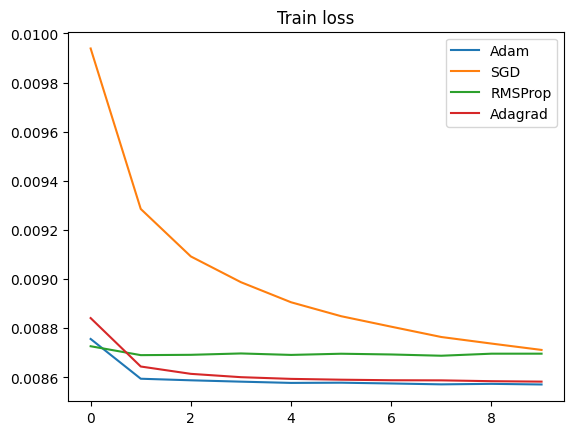

In [73]:
plt.plot(history_Adam['loss_train'], label='Adam')
plt.plot(history_SGD['loss_train'], label = 'SGD')
plt.plot(history_RMS['loss_train'], label = 'RMSProp')
plt.plot(history_Adagrad['loss_train'], label = 'Adagrad')
plt.legend()
plt.title('Train loss')
plt.show()

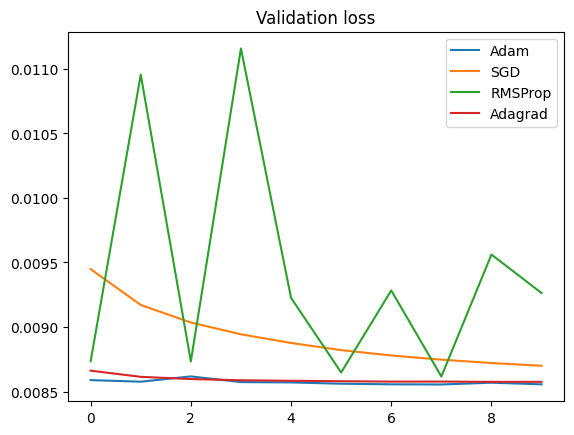

In [74]:
plt.plot(history_Adam['loss_val'], label='Adam')
plt.plot(history_SGD['loss_val'], label = 'SGD')
plt.plot(history_RMS['loss_val'], label = 'RMSProp')
plt.plot(history_Adagrad['loss_val'], label = 'Adagrad')
plt.legend()
plt.title('Validation loss')
plt.show()

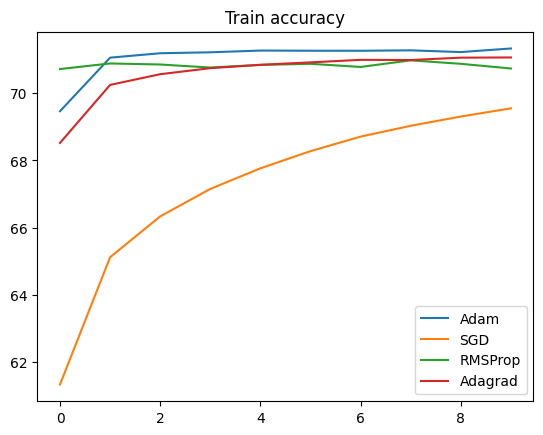

In [75]:
plt.plot(history_Adam['accuracy_train'], label='Adam')
plt.plot(history_SGD['accuracy_train'], label = 'SGD')
plt.plot(history_RMS['accuracy_train'], label = 'RMSProp')
plt.plot(history_Adagrad['accuracy_train'], label = 'Adagrad')
plt.legend()
plt.title('Train accuracy')
plt.show()

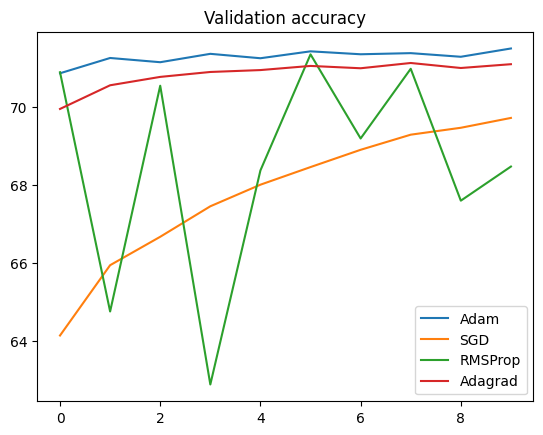

In [76]:
plt.plot(history_Adam['accuracy_val'], label='Adam')
plt.plot(history_SGD['accuracy_val'], label = 'SGD')
plt.plot(history_RMS['accuracy_val'], label = 'RMSProp')
plt.plot(history_Adagrad['accuracy_val'], label = 'Adagrad')
plt.legend()
plt.title('Validation accuracy')
plt.show()